In [1]:

from TRIOMA.tools.Extractors.PAV import Component,Fluid,Membrane, Geometry
import TRIOMA.tools.materials as materials

Let's define a Pipe component. A Component is made of a fluid class, flowing inside the pipe, and a membrane class, which is the pipe. To define a fluid class we can define all properties or use pre-built materials with the set_properties_from_fluid_material method (which takes as input a Fluid material class, here returned by the material.Flibe function).
Component specific properties of the fluid representation, such as Temperature, hydraulic diameter and fluid velocity, are not material independent, so they must be specified by the user. 

In [2]:
T=973.15
d_hyd=25.4E-3
U0=2.5
flibe=Fluid(d_Hyd=d_hyd,U0=U0)
flibe.set_properties_from_fluid_material(materials.Flibe(T))

With ease we can define a membrane, the solid material of the pipe. Geometric properties (not material-dependent) only include the thickness of the pipe. 

In [3]:
Steel = Membrane( thick=0.25E-3,k_r=1E9,k_d=1E9)
Steel.set_properties_from_solid_material(materials.Steel(T))

Now we define a component. It takes as input a fluid, a membrane and the inlet concentration of the component. The inlet concentration is not defined by the fluid class as some other components such as the Breeding Blanket may behave differently. The lenght is a characteristic of the component, but it can be evaluated with some component methods itself (e.g: heat exchangers), therefore it is used as argument of the methods which need it and is treated as an external variable (this may change)

In [4]:
PAV_geom=Geometry(L=1,D=25.4E-3, thick=0.25E-3)
c_in=1E-3
PAV = Component(c_in=c_in, geometry=PAV_geom,fluid=flibe, membrane=Steel, name='PAV') 

Now we can use pre-built methods to evaluate the T extraction efficiency of the component and the outlet concentration.

In [5]:
PAV.get_efficiency(c_guess=c_in/1E3)
PAV.outlet_c_comp()

0.0009907673727938785

We can also inspect component variables. 

In [6]:
PAV.analytical_efficiency()
PAV.inspect("eff")
PAV.inspect("eff_an")
print("Relative efficiency error",abs(PAV.eff-PAV.eff_an)/PAV.eff)

eff: 0.009232627206121535
eff_an: 0.009232247721287501
Relative efficiency error 4.110258386501566e-05


Or inspect the whole component together with the Fluid class and Membrane class by using the inspect method without an argument

c_in: 0.001
geometry: <TRIOMA.tools.Extractors.PipeSubclasses.Geometry object at 0x00000237DD6200D0>
eff: 0.009232627206121535
n_pipes: (1,)
fluid: <TRIOMA.tools.Extractors.PipeSubclasses.Fluid object at 0x00000237EEA9D690>
membrane: <TRIOMA.tools.Extractors.PipeSubclasses.Membrane object at 0x00000237DD5AAB90>
name: PAV
loss: False
inv: None
p_out: 1e-15
delta_p: None
U: None
pumping_power: None
cost: None
update_attribute: <bound method Component.custom_update_attribute of <TRIOMA.tools.Extractors.PAV.Component object at 0x00000237EECB20D0>>
H: 1.35635767164547e+16
W: 4624900740437019.0
J_perm: -2.9188119908377013e-07
c_out: 0.0009907673727938785
tau: 0.010229541888345899
alpha: 0.0021926203098999834
xi: 2.1926203098999832
eff_an: 0.009232247721287501


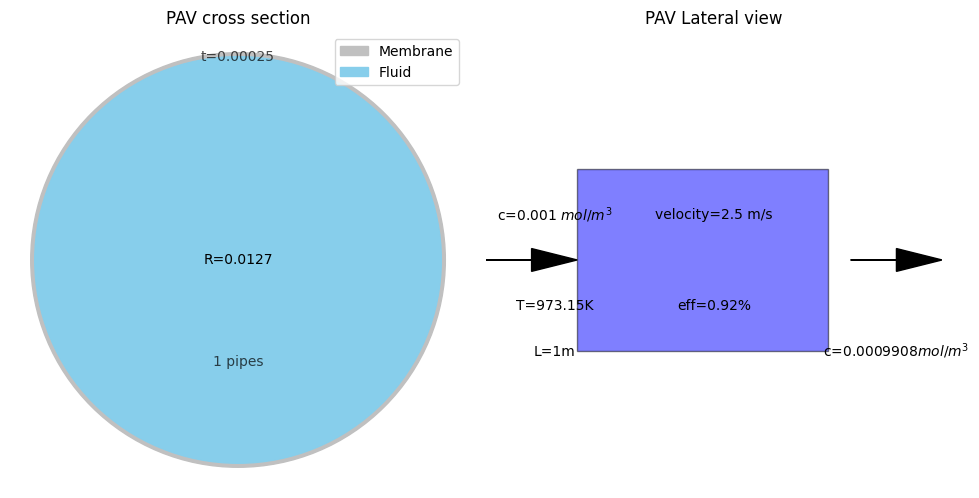

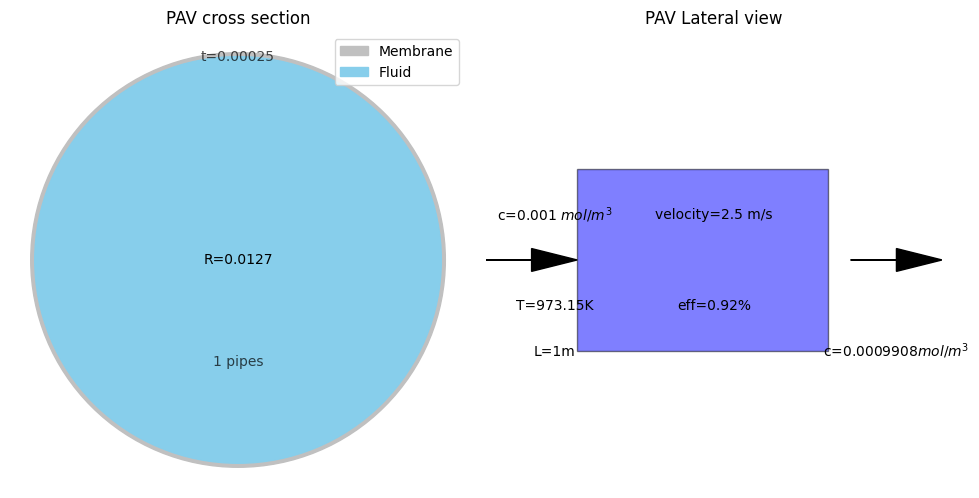

In [7]:
PAV.inspect()
PAV.plot_component()